<a href="https://colab.research.google.com/github/jerryk42/SemEval-Food-Hazard-Detection-Challenge-2025/blob/main/Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup and Configuration

In [ ]:
# Importing necessary libraries
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm  # Import tqdm for progress bars
import matplotlib.pyplot as plt
from google.colab import drive

In [ ]:
# Mounting on google drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Configuration of the model
config = {
    'max_len': 256,
    'batch_size': 16,
    'learning_rate': 0.00005,
    'epochs': 100, # Number of training epochs
    'model_name': "dmis-lab/biobert-base-cased-v1.1"  # BioBERT model
}


In [ ]:
# Set device for training (GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


# Data Loading and Preprocessing

In [ ]:
# URL of the raw file
url = "https://raw.githubusercontent.com/food-hazard-detection-semeval-2025/food-hazard-detection-semeval-2025.github.io/refs/heads/main/data/incidents_train.csv"

# Read the CSV file into a DataFrame
df = pd.read_csv(url)

# Display the first few rows of the DataFrame
print(df.head())

   Unnamed: 0  year  month  day country                             title  \
0           0  1994      1    7      us  Recall Notification: FSIS-024-94   
1           1  1994      3   10      us  Recall Notification: FSIS-033-94   
2           2  1994      3   28      us  Recall Notification: FSIS-014-94   
3           3  1994      4    3      us  Recall Notification: FSIS-009-94   
4           4  1994      7    1      us  Recall Notification: FSIS-001-94   

                                                text hazard-category  \
0  Case Number: 024-94   \n            Date Opene...      biological   
1  Case Number: 033-94   \n            Date Opene...      biological   
2  Case Number: 014-94   \n            Date Opene...      biological   
3  Case Number: 009-94   \n            Date Opene...  foreign bodies   
4  Case Number: 001-94   \n            Date Opene...  foreign bodies   

               product-category                  hazard  \
0  meat, egg and dairy products  listeria mon

In [ ]:
# Drop the first column
df = df.drop(df.columns[0], axis=1)

In [ ]:
# Check the structure of the DataFrame
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5082 entries, 0 to 5081
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   year              5082 non-null   int64 
 1   month             5082 non-null   int64 
 2   day               5082 non-null   int64 
 3   country           5082 non-null   object
 4   title             5082 non-null   object
 5   text              5082 non-null   object
 6   hazard-category   5082 non-null   object
 7   product-category  5082 non-null   object
 8   hazard            5082 non-null   object
 9   product           5082 non-null   object
dtypes: int64(3), object(7)
memory usage: 397.2+ KB
None


In [ ]:
# Function to clean text by removing non-alphanumeric characters and converting to lowercase
def clean_text(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text) # Remove special characters
    text = text.lower() # Convert to lowercase
    text = ' '.join(text.split()) # Remove extra spaces
    return text

# Apply text cleaning to the 'text' column
df['text'] = df['text'].apply(clean_text)

# Tokenization

In [ ]:
# Load tokenizer for BioBERT
tokenizer = AutoTokenizer.from_pretrained(config['model_name'])

In [ ]:
# Define relevant features and targets
features = ['year', 'month', 'day', 'country']
subtask1 = ['hazard-category','product-category'] # Tasks for subtask 1
subtask2 = ['hazard','product'] # Tasks for subtask 2

In [ ]:
# Encode target labels to numeric values
label_encoders = {}
for target in subtask1 + subtask2:
    le = LabelEncoder()
    df[target] = le.fit_transform(df[target])  # Fit and transform the target labels
    label_encoders[target] = le


# Dataset Preparation

In [ ]:
# Custom Dataset class for PyTorch
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }


In [ ]:
# Function to prepare data splits for training and testing
def prepare_data(text_column):
    X = df[features + [text_column]] # Combine features with the specified text column
    y_subtask1 = df[subtask1]
    y_subtask2 = df[subtask2]

    data_splits = {}
    for target in subtask1 + subtask2:
        # Split into training and test sets
        X_train, X_test, y_train, y_test = train_test_split(
            X, df[target], test_size=0.1, random_state=42
        )

        # Reset indices for consistency
        X_train = X_train.reset_index(drop=True)
        y_train = y_train.reset_index(drop=True)
        X_test = X_test.reset_index(drop=True)
        y_test = y_test.reset_index(drop=True)

        data_splits[target] = (X_train, X_test, y_train, y_test)

    return data_splits


In [ ]:
# Prepare data splits for title and text tasks
title_splits = prepare_data('title')
text_splits = prepare_data('text')


# Training and Evaluation

In [ ]:
# Function to train and evaluate a model for given tasks
def train_and_evaluate_nn(data_splits, targets, model_type='title', early_stopping_patience=6, lr_reduce_factor=0.05):
    f1_scores = []  # Store F1-scores for each task

    for target in targets:
        print(f"\nStarting training for task: {target}")  # Print task message

        X_train, X_test, y_train, y_test = data_splits[target]

        # Prepare text data using the tokenizer
        if model_type == 'title':
            texts_train = X_train['title'].values
            texts_test = X_test['title'].values
        else:
            texts_train = X_train['text'].values
            texts_test = X_test['text'].values

        # Create DataLoader for training and testing
        train_dataset = TextDataset(texts_train, y_train, tokenizer, config['max_len'])
        test_dataset = TextDataset(texts_test, y_test, tokenizer, config['max_len'])

        train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)

        # Model setup
        num_labels = len(label_encoders[target].classes_)
        model = AutoModelForSequenceClassification.from_pretrained(config['model_name'], num_labels=num_labels).to(device)

        optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=lr_reduce_factor, patience=3, verbose=True)
        criterion = nn.CrossEntropyLoss()

        # Training process
        model.train()
        best_loss = float('inf')
        early_stop_counter = 0

        for epoch in range(config['epochs']):
            print(f"Epoch {epoch+1}/{config['epochs']} - Training: {target}")
            progress_bar = tqdm(train_loader, desc=f"Training Epoch {epoch+1}", total=len(train_loader), leave=True)
            epoch_loss = 0.0

            for batch in progress_bar:
                optimizer.zero_grad()
                input_ids = batch['input_ids'].squeeze(1).to(device)
                attention_mask = batch['attention_mask'].squeeze(1).to(device)
                labels = batch['label'].to(device)

                outputs = model(input_ids, attention_mask=attention_mask)
                loss = criterion(outputs.logits, labels)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
                progress_bar.set_postfix(loss=loss.item())

            # Average loss for the epoch
            avg_epoch_loss = epoch_loss / len(train_loader)
            print(f"Average Training Loss for Epoch {epoch+1}: {avg_epoch_loss}")

            # Evaluate on the test set to compute validation loss
            val_loss = 0.0
            model.eval()
            with torch.no_grad():
                for batch in test_loader:
                    input_ids = batch['input_ids'].squeeze(1).to(device)
                    attention_mask = batch['attention_mask'].squeeze(1).to(device)
                    labels = batch['label'].to(device)

                    outputs = model(input_ids, attention_mask=attention_mask)
                    loss = criterion(outputs.logits, labels)
                    val_loss += loss.item()

            avg_val_loss = val_loss / len(test_loader)
            print(f"Validation Loss after Epoch {epoch+1}: {avg_val_loss}")

            # Step the scheduler with the validation loss
            scheduler.step(avg_val_loss)

            # Early stopping check
            if avg_val_loss < best_loss:
                best_loss = avg_val_loss
                early_stop_counter = 0
                torch.save(model.state_dict(), f"best_model_{target}.pt")  # Save the best model
            else:
                early_stop_counter += 1
                print(f"Early stopping counter: {early_stop_counter}/{early_stopping_patience}")

            if early_stop_counter >= early_stopping_patience:
                print("Early stopping triggered.")
                break

        # Load the best model for evaluation
        model.load_state_dict(torch.load(f"best_model_{target}.pt"))

        # Evaluation process
        print(f"Evaluating model for task: {target}")
        model.eval()
        y_preds = []
        y_true = []
        with torch.no_grad():
            for batch in tqdm(test_loader, desc="Evaluating", total=len(test_loader), leave=True):
                input_ids = batch['input_ids'].squeeze(1).to(device)
                attention_mask = batch['attention_mask'].squeeze(1).to(device)
                labels = batch['label'].to(device)
                outputs = model(input_ids, attention_mask=attention_mask)
                _, preds = torch.max(outputs.logits, dim=1)
                y_preds.extend(preds.cpu().numpy())
                y_true.extend(labels.cpu().numpy())

        # Decode labels back to original categories using the label encoder
        decoded_preds = label_encoders[target].inverse_transform(y_preds)
        decoded_true = label_encoders[target].inverse_transform(y_true)

        # Calculate F1 score for the task
        f1 = f1_score(decoded_true, decoded_preds, average='weighted')
        f1_scores.append(f1)
        print(f"F1-Score for {target}: {f1}")

        # Print classification report
        print(f"Classification Report for {target}:\n")
        print(classification_report(decoded_true, decoded_preds, zero_division=0))

    return f1_scores  # Return the list of F1 scores for plotting


# Execution

In [ ]:
# Train and evaluate for title
print("\nTraining and Evaluating for Title Tasks:")
title_f1_scores = train_and_evaluate_nn(title_splits, subtask1 + subtask2, model_type='title')


Training and Evaluating for Title Tasks:

Starting training for task: hazard-category


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/100 - Training: hazard-category


Training Epoch 1: 100%|██████████| 286/286 [01:24<00:00,  3.37it/s, loss=0.83]


Average Training Loss for Epoch 1: 0.8526037928837162
Validation Loss after Epoch 1: 0.6488561267033219
Epoch 2/100 - Training: hazard-category


Training Epoch 2: 100%|██████████| 286/286 [01:23<00:00,  3.43it/s, loss=0.577]


Average Training Loss for Epoch 2: 0.49519425415648866
Validation Loss after Epoch 2: 0.595657218946144
Epoch 3/100 - Training: hazard-category


Training Epoch 3: 100%|██████████| 286/286 [01:23<00:00,  3.44it/s, loss=0.602]


Average Training Loss for Epoch 3: 0.3401822982114981
Validation Loss after Epoch 3: 0.6418999996967614
Early stopping counter: 1/6
Epoch 4/100 - Training: hazard-category


Training Epoch 4: 100%|██████████| 286/286 [01:23<00:00,  3.44it/s, loss=0.537]


Average Training Loss for Epoch 4: 0.22676551583633348
Validation Loss after Epoch 4: 0.6353647615760565
Early stopping counter: 2/6
Epoch 5/100 - Training: hazard-category


Training Epoch 5: 100%|██████████| 286/286 [01:23<00:00,  3.44it/s, loss=0.273]


Average Training Loss for Epoch 5: 0.13321629631450282
Validation Loss after Epoch 5: 0.7634691828861833
Early stopping counter: 3/6
Epoch 6/100 - Training: hazard-category


Training Epoch 6: 100%|██████████| 286/286 [01:23<00:00,  3.44it/s, loss=0.00477]


Average Training Loss for Epoch 6: 0.08040479364417415
Validation Loss after Epoch 6: 0.7402717540971935
Early stopping counter: 4/6
Epoch 7/100 - Training: hazard-category


Training Epoch 7: 100%|██████████| 286/286 [01:23<00:00,  3.44it/s, loss=0.0112]


Average Training Loss for Epoch 7: 0.04642826820466459
Validation Loss after Epoch 7: 0.7602066892432049
Early stopping counter: 5/6
Epoch 8/100 - Training: hazard-category


Training Epoch 8: 100%|██████████| 286/286 [01:23<00:00,  3.44it/s, loss=0.00289]


Average Training Loss for Epoch 8: 0.03325558706655629
Validation Loss after Epoch 8: 0.7760384087450802
Early stopping counter: 6/6
Early stopping triggered.


<ipython-input-48-cb47ea6c2053>:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"best_model_{target}.pt"))


Evaluating model for task: hazard-category


Evaluating: 100%|██████████| 32/32 [00:02<00:00, 11.03it/s]


F1-Score for hazard-category: 0.7875744067723562
Classification Report for hazard-category:

              precision    recall  f1-score   support

           0       0.86      0.89      0.87       188
           1       0.76      0.95      0.85       171
           2       0.70      0.60      0.65        35
           3       0.00      0.00      0.00         5
           4       0.85      0.69      0.76        58
           5       0.79      0.39      0.52        28
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         3
           8       0.88      0.47      0.61        15
           9       1.00      0.20      0.33         5

    accuracy                           0.80       509
   macro avg       0.58      0.42      0.46       509
weighted avg       0.80      0.80      0.79       509


Starting training for task: product-category


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/100 - Training: product-category


Training Epoch 1: 100%|██████████| 286/286 [01:24<00:00,  3.39it/s, loss=1.32]


Average Training Loss for Epoch 1: 1.8438789517312617
Validation Loss after Epoch 1: 1.2205164907500148
Epoch 2/100 - Training: product-category


Training Epoch 2: 100%|██████████| 286/286 [01:23<00:00,  3.44it/s, loss=0.96]


Average Training Loss for Epoch 2: 0.9666668872733216
Validation Loss after Epoch 2: 1.0141451554372907
Epoch 3/100 - Training: product-category


Training Epoch 3: 100%|██████████| 286/286 [01:23<00:00,  3.44it/s, loss=0.14]


Average Training Loss for Epoch 3: 0.5574097448920871
Validation Loss after Epoch 3: 0.9332389263436198
Epoch 4/100 - Training: product-category


Training Epoch 4: 100%|██████████| 286/286 [01:23<00:00,  3.44it/s, loss=0.12]


Average Training Loss for Epoch 4: 0.3238768228492537
Validation Loss after Epoch 4: 1.0378252658993006
Early stopping counter: 1/6
Epoch 5/100 - Training: product-category


Training Epoch 5: 100%|██████████| 286/286 [01:23<00:00,  3.44it/s, loss=0.0387]


Average Training Loss for Epoch 5: 0.20429519769716095
Validation Loss after Epoch 5: 1.075084287673235
Early stopping counter: 2/6
Epoch 6/100 - Training: product-category


Training Epoch 6: 100%|██████████| 286/286 [01:23<00:00,  3.44it/s, loss=0.0294]


Average Training Loss for Epoch 6: 0.1041429436283668
Validation Loss after Epoch 6: 1.15093476139009
Early stopping counter: 3/6
Epoch 7/100 - Training: product-category


Training Epoch 7: 100%|██████████| 286/286 [01:23<00:00,  3.44it/s, loss=0.0157]


Average Training Loss for Epoch 7: 0.06087356248310396
Validation Loss after Epoch 7: 1.2289086086675525
Early stopping counter: 4/6
Epoch 8/100 - Training: product-category


Training Epoch 8: 100%|██████████| 286/286 [01:23<00:00,  3.44it/s, loss=0.0723]


Average Training Loss for Epoch 8: 0.030466587916081707
Validation Loss after Epoch 8: 1.2064156671985984
Early stopping counter: 5/6
Epoch 9/100 - Training: product-category


Training Epoch 9: 100%|██████████| 286/286 [01:23<00:00,  3.44it/s, loss=0.00616]


Average Training Loss for Epoch 9: 0.023333696284578865
Validation Loss after Epoch 9: 1.2085722163319588
Early stopping counter: 6/6
Early stopping triggered.


<ipython-input-48-cb47ea6c2053>:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"best_model_{target}.pt"))


Evaluating model for task: product-category


Evaluating: 100%|██████████| 32/32 [00:02<00:00, 11.07it/s]


F1-Score for product-category: 0.7238874589526265
Classification Report for product-category:

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         2
           1       0.66      0.74      0.70        54
           2       0.72      0.79      0.75        29
           3       0.32      0.30      0.31        20
           4       0.67      0.55      0.60        11
           5       0.50      0.33      0.40         3
           6       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         1
           9       0.73      0.73      0.73        56
          10       0.33      0.89      0.48         9
          12       0.97      0.88      0.92        33
          13       0.83      0.92      0.88       131
          14       1.00      0.62      0.77        16
          15       0.93      0.73      0.82        37
          16       0.00      0.00      0.00         1
          17       1.00      0.33      0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/100 - Training: hazard


Training Epoch 1: 100%|██████████| 286/286 [01:24<00:00,  3.38it/s, loss=2.96]


Average Training Loss for Epoch 1: 2.8747779214298808
Validation Loss after Epoch 1: 2.1031708363443613
Epoch 2/100 - Training: hazard


Training Epoch 2: 100%|██████████| 286/286 [01:23<00:00,  3.44it/s, loss=2.69]


Average Training Loss for Epoch 2: 1.8562578636032718
Validation Loss after Epoch 2: 1.7618765942752361
Epoch 3/100 - Training: hazard


Training Epoch 3: 100%|██████████| 286/286 [01:23<00:00,  3.44it/s, loss=0.903]


Average Training Loss for Epoch 3: 1.3682830971437734
Validation Loss after Epoch 3: 1.6314141619950533
Epoch 4/100 - Training: hazard


Training Epoch 4: 100%|██████████| 286/286 [01:23<00:00,  3.44it/s, loss=1.56]


Average Training Loss for Epoch 4: 1.0068876291071618
Validation Loss after Epoch 4: 1.592162722721696
Epoch 5/100 - Training: hazard


Training Epoch 5: 100%|██████████| 286/286 [01:23<00:00,  3.44it/s, loss=1.11]


Average Training Loss for Epoch 5: 0.7172761836017554
Validation Loss after Epoch 5: 1.5741683561354876
Epoch 6/100 - Training: hazard


Training Epoch 6: 100%|██████████| 286/286 [01:23<00:00,  3.43it/s, loss=0.379]


Average Training Loss for Epoch 6: 0.4978265080705181
Validation Loss after Epoch 6: 1.5918682347983122
Early stopping counter: 1/6
Epoch 7/100 - Training: hazard


Training Epoch 7: 100%|██████████| 286/286 [01:23<00:00,  3.44it/s, loss=0.204]


Average Training Loss for Epoch 7: 0.3424900842804488
Validation Loss after Epoch 7: 1.6944975974038243
Early stopping counter: 2/6
Epoch 8/100 - Training: hazard


Training Epoch 8: 100%|██████████| 286/286 [01:23<00:00,  3.44it/s, loss=0.167]


Average Training Loss for Epoch 8: 0.2469189565016569
Validation Loss after Epoch 8: 1.6649022363126278
Early stopping counter: 3/6
Epoch 9/100 - Training: hazard


Training Epoch 9: 100%|██████████| 286/286 [01:23<00:00,  3.43it/s, loss=0.0454]


Average Training Loss for Epoch 9: 0.17069614917313405
Validation Loss after Epoch 9: 1.7448944002389908
Early stopping counter: 4/6
Epoch 10/100 - Training: hazard


Training Epoch 10: 100%|██████████| 286/286 [01:23<00:00,  3.44it/s, loss=0.081]


Average Training Loss for Epoch 10: 0.11290546016722032
Validation Loss after Epoch 10: 1.7331780698150396
Early stopping counter: 5/6
Epoch 11/100 - Training: hazard


Training Epoch 11: 100%|██████████| 286/286 [01:23<00:00,  3.44it/s, loss=0.0103]


Average Training Loss for Epoch 11: 0.09654433079311377
Validation Loss after Epoch 11: 1.7271518744528294
Early stopping counter: 6/6
Early stopping triggered.


<ipython-input-48-cb47ea6c2053>:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"best_model_{target}.pt"))


Evaluating model for task: hazard


Evaluating: 100%|██████████| 32/32 [00:02<00:00, 11.04it/s]


F1-Score for hazard: 0.6353890281175577
Classification Report for hazard:

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         3
           5       0.33      0.75      0.46         4
           7       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         2
          14       1.00      0.20      0.33         5
          15       0.00      0.00      0.00         1
          17       0.36      0.76      0.49        17
          18       0.00      0.00      0.00         1
          19       0.00      0.00      0.00         1
          22       1.00      1.00      1.00         3
          23       0.00      0.00      0.00         1
      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/100 - Training: product


Training Epoch 1: 100%|██████████| 286/286 [01:24<00:00,  3.38it/s, loss=6.56]


Average Training Loss for Epoch 1: 6.245762296489902
Validation Loss after Epoch 1: 5.699641019105911
Epoch 2/100 - Training: product


Training Epoch 2: 100%|██████████| 286/286 [01:23<00:00,  3.44it/s, loss=5.64]


Average Training Loss for Epoch 2: 5.096462469000916
Validation Loss after Epoch 2: 4.903970472514629
Epoch 3/100 - Training: product


Training Epoch 3: 100%|██████████| 286/286 [01:23<00:00,  3.43it/s, loss=4.19]


Average Training Loss for Epoch 3: 4.17318730671089
Validation Loss after Epoch 3: 4.375159651041031
Epoch 4/100 - Training: product


Training Epoch 4: 100%|██████████| 286/286 [01:23<00:00,  3.43it/s, loss=3.17]


Average Training Loss for Epoch 4: 3.428116573737218
Validation Loss after Epoch 4: 4.037622183561325
Epoch 5/100 - Training: product


Training Epoch 5: 100%|██████████| 286/286 [01:23<00:00,  3.42it/s, loss=3.01]


Average Training Loss for Epoch 5: 2.7946656546392643
Validation Loss after Epoch 5: 3.8166015222668648
Epoch 6/100 - Training: product


Training Epoch 6: 100%|██████████| 286/286 [01:23<00:00,  3.43it/s, loss=1.7]


Average Training Loss for Epoch 6: 2.238891651163568
Validation Loss after Epoch 6: 3.6735625490546227
Epoch 7/100 - Training: product


Training Epoch 7: 100%|██████████| 286/286 [01:23<00:00,  3.42it/s, loss=1.24]


Average Training Loss for Epoch 7: 1.7802587830936991
Validation Loss after Epoch 7: 3.4671257212758064
Epoch 8/100 - Training: product


Training Epoch 8: 100%|██████████| 286/286 [01:23<00:00,  3.43it/s, loss=0.735]


Average Training Loss for Epoch 8: 1.3949574553049529
Validation Loss after Epoch 8: 3.399665117263794
Epoch 9/100 - Training: product


Training Epoch 9: 100%|██████████| 286/286 [01:23<00:00,  3.43it/s, loss=0.962]


Average Training Loss for Epoch 9: 1.0970371854263585
Validation Loss after Epoch 9: 3.315527554601431
Epoch 10/100 - Training: product


Training Epoch 10: 100%|██████████| 286/286 [01:23<00:00,  3.43it/s, loss=1.12]


Average Training Loss for Epoch 10: 0.8699033030575806
Validation Loss after Epoch 10: 3.3048871122300625
Epoch 11/100 - Training: product


Training Epoch 11: 100%|██████████| 286/286 [01:23<00:00,  3.43it/s, loss=0.715]


Average Training Loss for Epoch 11: 0.6901829111409354
Validation Loss after Epoch 11: 3.239421673119068
Epoch 12/100 - Training: product


Training Epoch 12: 100%|██████████| 286/286 [01:23<00:00,  3.44it/s, loss=0.38]


Average Training Loss for Epoch 12: 0.5438920856824705
Validation Loss after Epoch 12: 3.235342115163803
Epoch 13/100 - Training: product


Training Epoch 13: 100%|██████████| 286/286 [01:23<00:00,  3.43it/s, loss=1.15]


Average Training Loss for Epoch 13: 0.4341181502319299
Validation Loss after Epoch 13: 3.25559339299798
Early stopping counter: 1/6
Epoch 14/100 - Training: product


Training Epoch 14: 100%|██████████| 286/286 [01:23<00:00,  3.43it/s, loss=0.497]


Average Training Loss for Epoch 14: 0.346710118966607
Validation Loss after Epoch 14: 3.2642058059573174
Early stopping counter: 2/6
Epoch 15/100 - Training: product


Training Epoch 15: 100%|██████████| 286/286 [01:23<00:00,  3.43it/s, loss=0.289]


Average Training Loss for Epoch 15: 0.2807211483718007
Validation Loss after Epoch 15: 3.2564377449452877
Early stopping counter: 3/6
Epoch 16/100 - Training: product


Training Epoch 16: 100%|██████████| 286/286 [01:23<00:00,  3.43it/s, loss=0.246]


Average Training Loss for Epoch 16: 0.22148123844624398
Validation Loss after Epoch 16: 3.31188852712512
Early stopping counter: 4/6
Epoch 17/100 - Training: product


Training Epoch 17: 100%|██████████| 286/286 [01:23<00:00,  3.44it/s, loss=0.102]


Average Training Loss for Epoch 17: 0.16965653797468314
Validation Loss after Epoch 17: 3.305970475077629
Early stopping counter: 5/6
Epoch 18/100 - Training: product


Training Epoch 18: 100%|██████████| 286/286 [01:23<00:00,  3.43it/s, loss=0.122]


Average Training Loss for Epoch 18: 0.15462044865492133
Validation Loss after Epoch 18: 3.302078977227211
Early stopping counter: 6/6
Early stopping triggered.


<ipython-input-48-cb47ea6c2053>:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"best_model_{target}.pt"))


Evaluating model for task: product


Evaluating: 100%|██████████| 32/32 [00:02<00:00, 11.06it/s]

F1-Score for product: 0.4739425742763013
Classification Report for product:

              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           2       0.60      0.60      0.60         5
           4       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         1
          13       1.00      1.00      1.00         3
          19       0.67      1.00      0.80         2
          20       0.33      1.00      0.50         1
          22       1.00      1.00      1.00         1
          23       0.00      0.00      0.00         0
          24       0.00      0.00      0.00         1
          27       0.00      0.00      0.00         1
          31       0.00      0.00      0.00         1
          35       0.00      0.00      0.00         1
          38       0.67      1.00      0.80         2
    

In [ ]:
# Train and evaluate for text
print("\nTraining and Evaluating for Text Tasks:")
text_f1_scores = train_and_evaluate_nn(text_splits, subtask1 + subtask2, model_type='text')



Training and Evaluating for Text Tasks:

Starting training for task: hazard-category


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/100 - Training: hazard-category


Training Epoch 1: 100%|██████████| 286/286 [01:36<00:00,  2.98it/s, loss=0.232]


Average Training Loss for Epoch 1: 0.7706871191104809
Validation Loss after Epoch 1: 0.46837801905348897
Epoch 2/100 - Training: hazard-category


Training Epoch 2: 100%|██████████| 286/286 [01:35<00:00,  3.01it/s, loss=0.265]


Average Training Loss for Epoch 2: 0.31442130603208823
Validation Loss after Epoch 2: 0.2639065669500269
Epoch 3/100 - Training: hazard-category


Training Epoch 3: 100%|██████████| 286/286 [01:35<00:00,  3.00it/s, loss=0.0702]


Average Training Loss for Epoch 3: 0.1959659682840786
Validation Loss after Epoch 3: 0.24787315947469324
Epoch 4/100 - Training: hazard-category


Training Epoch 4: 100%|██████████| 286/286 [01:35<00:00,  3.00it/s, loss=0.0851]


Average Training Loss for Epoch 4: 0.14735181523825636
Validation Loss after Epoch 4: 0.2584001724026166
Early stopping counter: 1/6
Epoch 5/100 - Training: hazard-category


Training Epoch 5: 100%|██████████| 286/286 [01:35<00:00,  3.00it/s, loss=0.0737]


Average Training Loss for Epoch 5: 0.1205618751065975
Validation Loss after Epoch 5: 0.21943968057166785
Epoch 6/100 - Training: hazard-category


Training Epoch 6: 100%|██████████| 286/286 [01:35<00:00,  3.01it/s, loss=0.0191]


Average Training Loss for Epoch 6: 0.08742925144123057
Validation Loss after Epoch 6: 0.23688465352461208
Early stopping counter: 1/6
Epoch 7/100 - Training: hazard-category


Training Epoch 7: 100%|██████████| 286/286 [01:35<00:00,  3.00it/s, loss=0.0184]


Average Training Loss for Epoch 7: 0.09445655694837077
Validation Loss after Epoch 7: 0.2831707904115319
Early stopping counter: 2/6
Epoch 8/100 - Training: hazard-category


Training Epoch 8: 100%|██████████| 286/286 [01:35<00:00,  3.01it/s, loss=0.0038]


Average Training Loss for Epoch 8: 0.07054947504376459
Validation Loss after Epoch 8: 0.2759665162448073
Early stopping counter: 3/6
Epoch 9/100 - Training: hazard-category


Training Epoch 9: 100%|██████████| 286/286 [01:35<00:00,  3.00it/s, loss=0.0249]


Average Training Loss for Epoch 9: 0.07767248125763128
Validation Loss after Epoch 9: 0.243028767312353
Early stopping counter: 4/6
Epoch 10/100 - Training: hazard-category


Training Epoch 10: 100%|██████████| 286/286 [01:35<00:00,  3.01it/s, loss=0.00573]


Average Training Loss for Epoch 10: 0.048096020889983
Validation Loss after Epoch 10: 0.2189566225570161
Epoch 11/100 - Training: hazard-category


Training Epoch 11: 100%|██████████| 286/286 [01:35<00:00,  3.00it/s, loss=0.00579]


Average Training Loss for Epoch 11: 0.02857769754637111
Validation Loss after Epoch 11: 0.21899004193983274
Early stopping counter: 1/6
Epoch 12/100 - Training: hazard-category


Training Epoch 12: 100%|██████████| 286/286 [01:34<00:00,  3.01it/s, loss=0.392]


Average Training Loss for Epoch 12: 0.022779983033220954
Validation Loss after Epoch 12: 0.21912154300662223
Early stopping counter: 2/6
Epoch 13/100 - Training: hazard-category


Training Epoch 13: 100%|██████████| 286/286 [01:34<00:00,  3.01it/s, loss=0.00262]


Average Training Loss for Epoch 13: 0.019034036523108925
Validation Loss after Epoch 13: 0.22276905825856375
Early stopping counter: 3/6
Epoch 14/100 - Training: hazard-category


Training Epoch 14: 100%|██████████| 286/286 [01:34<00:00,  3.01it/s, loss=0.003]


Average Training Loss for Epoch 14: 0.01515900996315026
Validation Loss after Epoch 14: 0.22952274078852497
Early stopping counter: 4/6
Epoch 15/100 - Training: hazard-category


Training Epoch 15: 100%|██████████| 286/286 [01:35<00:00,  3.01it/s, loss=0.00792]


Average Training Loss for Epoch 15: 0.013088132144062669
Validation Loss after Epoch 15: 0.2294168716398417
Early stopping counter: 5/6
Epoch 16/100 - Training: hazard-category


Training Epoch 16: 100%|██████████| 286/286 [01:35<00:00,  3.00it/s, loss=0.00204]


Average Training Loss for Epoch 16: 0.01270870596717496
Validation Loss after Epoch 16: 0.22961450154252816
Early stopping counter: 6/6
Early stopping triggered.


<ipython-input-48-cb47ea6c2053>:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"best_model_{target}.pt"))


Evaluating model for task: hazard-category


Evaluating: 100%|██████████| 32/32 [00:03<00:00,  9.16it/s]


F1-Score for hazard-category: 0.9516665880294135
Classification Report for hazard-category:

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       188
           1       1.00      0.99      0.99       171
           2       0.85      1.00      0.92        35
           3       0.00      0.00      0.00         5
           4       1.00      0.98      0.99        58
           5       0.85      0.82      0.84        28
           6       1.00      1.00      1.00         1
           7       0.60      1.00      0.75         3
           8       0.83      0.67      0.74        15
           9       0.75      0.60      0.67         5

    accuracy                           0.96       509
   macro avg       0.79      0.80      0.79       509
weighted avg       0.95      0.96      0.95       509


Starting training for task: product-category


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/100 - Training: product-category


Training Epoch 1: 100%|██████████| 286/286 [01:36<00:00,  2.97it/s, loss=2.27]


Average Training Loss for Epoch 1: 2.1979285536946116
Validation Loss after Epoch 1: 2.018518630415201
Epoch 2/100 - Training: product-category


Training Epoch 2: 100%|██████████| 286/286 [01:35<00:00,  3.01it/s, loss=1.38]


Average Training Loss for Epoch 2: 1.5341497301221727
Validation Loss after Epoch 2: 1.2957117278128862
Epoch 3/100 - Training: product-category


Training Epoch 3: 100%|██████████| 286/286 [01:35<00:00,  3.01it/s, loss=1.29]


Average Training Loss for Epoch 3: 0.9902159078763082
Validation Loss after Epoch 3: 1.1544393710792065
Epoch 4/100 - Training: product-category


Training Epoch 4: 100%|██████████| 286/286 [01:35<00:00,  3.01it/s, loss=1.04]


Average Training Loss for Epoch 4: 0.6319804662070074
Validation Loss after Epoch 4: 1.006431708112359
Epoch 5/100 - Training: product-category


Training Epoch 5: 100%|██████████| 286/286 [01:34<00:00,  3.01it/s, loss=0.506]


Average Training Loss for Epoch 5: 0.4127053035279879
Validation Loss after Epoch 5: 1.1475233854725957
Early stopping counter: 1/6
Epoch 6/100 - Training: product-category


Training Epoch 6: 100%|██████████| 286/286 [01:35<00:00,  3.01it/s, loss=0.0858]


Average Training Loss for Epoch 6: 0.27381727714221793
Validation Loss after Epoch 6: 1.0357054118067026
Early stopping counter: 2/6
Epoch 7/100 - Training: product-category


Training Epoch 7: 100%|██████████| 286/286 [01:34<00:00,  3.01it/s, loss=0.0254]


Average Training Loss for Epoch 7: 0.18665586605381507
Validation Loss after Epoch 7: 1.0345043493434787
Early stopping counter: 3/6
Epoch 8/100 - Training: product-category


Training Epoch 8: 100%|██████████| 286/286 [01:34<00:00,  3.01it/s, loss=0.0186]


Average Training Loss for Epoch 8: 0.152876228041999
Validation Loss after Epoch 8: 1.0867385184392333
Early stopping counter: 4/6
Epoch 9/100 - Training: product-category


Training Epoch 9: 100%|██████████| 286/286 [01:35<00:00,  3.01it/s, loss=0.0162]


Average Training Loss for Epoch 9: 0.07538083638227382
Validation Loss after Epoch 9: 1.0935583664104342
Early stopping counter: 5/6
Epoch 10/100 - Training: product-category


Training Epoch 10: 100%|██████████| 286/286 [01:35<00:00,  3.01it/s, loss=0.0112]


Average Training Loss for Epoch 10: 0.05190129518847574
Validation Loss after Epoch 10: 1.1145181995816529
Early stopping counter: 6/6
Early stopping triggered.


<ipython-input-48-cb47ea6c2053>:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"best_model_{target}.pt"))


Evaluating model for task: product-category


Evaluating: 100%|██████████| 32/32 [00:03<00:00,  9.07it/s]


F1-Score for product-category: 0.7371129863519751
Classification Report for product-category:

              precision    recall  f1-score   support

           0       0.40      1.00      0.57         2
           1       0.74      0.65      0.69        54
           2       0.56      0.79      0.66        29
           3       0.37      0.35      0.36        20
           4       0.67      0.73      0.70        11
           5       1.00      0.33      0.50         3
           6       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         1
           9       0.83      0.71      0.77        56
          10       0.54      0.78      0.64         9
          11       0.00      0.00      0.00         0
          12       0.83      0.91      0.87        33
          13       0.84      0.91      0.88       131
          14       1.00      0.75      0.86        16
          15       0.92      0.65      0.76        37
          16       0.00      0.00      0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/100 - Training: hazard


Training Epoch 1: 100%|██████████| 286/286 [01:36<00:00,  2.97it/s, loss=1.65]


Average Training Loss for Epoch 1: 2.332836267935646
Validation Loss after Epoch 1: 1.2381371101364493
Epoch 2/100 - Training: hazard


Training Epoch 2: 100%|██████████| 286/286 [01:35<00:00,  3.00it/s, loss=1.03]


Average Training Loss for Epoch 2: 1.1112476558118434
Validation Loss after Epoch 2: 0.9128205412998796
Epoch 3/100 - Training: hazard


Training Epoch 3: 100%|██████████| 286/286 [01:35<00:00,  3.01it/s, loss=0.71]


Average Training Loss for Epoch 3: 0.7712628314909818
Validation Loss after Epoch 3: 0.7799744604853913
Epoch 4/100 - Training: hazard


Training Epoch 4: 100%|██████████| 286/286 [01:35<00:00,  3.00it/s, loss=0.937]


Average Training Loss for Epoch 4: 0.5717579772552619
Validation Loss after Epoch 4: 0.7240316862007603
Epoch 5/100 - Training: hazard


Training Epoch 5: 100%|██████████| 286/286 [01:35<00:00,  3.00it/s, loss=0.545]


Average Training Loss for Epoch 5: 0.4190693744360567
Validation Loss after Epoch 5: 0.6807429093169048
Epoch 6/100 - Training: hazard


Training Epoch 6: 100%|██████████| 286/286 [01:35<00:00,  3.00it/s, loss=0.277]


Average Training Loss for Epoch 6: 0.3433654022539829
Validation Loss after Epoch 6: 0.7161517232307233
Early stopping counter: 1/6
Epoch 7/100 - Training: hazard


Training Epoch 7: 100%|██████████| 286/286 [01:35<00:00,  3.00it/s, loss=0.096]


Average Training Loss for Epoch 7: 0.2754847154841869
Validation Loss after Epoch 7: 0.6471359225106426
Epoch 8/100 - Training: hazard


Training Epoch 8: 100%|██████████| 286/286 [01:35<00:00,  3.00it/s, loss=0.568]


Average Training Loss for Epoch 8: 0.22483270096924754
Validation Loss after Epoch 8: 0.6630142452777363
Early stopping counter: 1/6
Epoch 9/100 - Training: hazard


Training Epoch 9: 100%|██████████| 286/286 [01:35<00:00,  3.01it/s, loss=0.11]


Average Training Loss for Epoch 9: 0.15508749149739742
Validation Loss after Epoch 9: 0.6639894533727784
Early stopping counter: 2/6
Epoch 10/100 - Training: hazard


Training Epoch 10: 100%|██████████| 286/286 [01:35<00:00,  3.00it/s, loss=0.38]


Average Training Loss for Epoch 10: 0.13995407334483273
Validation Loss after Epoch 10: 0.7371051034424454
Early stopping counter: 3/6
Epoch 11/100 - Training: hazard


Training Epoch 11: 100%|██████████| 286/286 [01:35<00:00,  3.01it/s, loss=0.0107]


Average Training Loss for Epoch 11: 0.10832784418016672
Validation Loss after Epoch 11: 0.7422684984921943
Early stopping counter: 4/6
Epoch 12/100 - Training: hazard


Training Epoch 12: 100%|██████████| 286/286 [01:35<00:00,  3.01it/s, loss=0.0371]


Average Training Loss for Epoch 12: 0.055243706444630045
Validation Loss after Epoch 12: 0.731630021968158
Early stopping counter: 5/6
Epoch 13/100 - Training: hazard


Training Epoch 13: 100%|██████████| 286/286 [01:35<00:00,  3.01it/s, loss=0.0103]


Average Training Loss for Epoch 13: 0.04423666679482725
Validation Loss after Epoch 13: 0.7327738243329804
Early stopping counter: 6/6
Early stopping triggered.


<ipython-input-48-cb47ea6c2053>:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"best_model_{target}.pt"))


Evaluating model for task: hazard


Evaluating: 100%|██████████| 32/32 [00:03<00:00,  9.11it/s]


F1-Score for hazard: 0.8547971420586762
Classification Report for hazard:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         3
           5       0.67      1.00      0.80         4
           7       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          11       1.00      1.00      1.00         1
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         2
          14       1.00      0.80      0.89         5
          15       0.00      0.00      0.00         1
          17       0.80      0.94      0.86        17
          18       0.00      0.00      0.00         1
          19       0.50      1.00      0.67         1
          22       1.00      1.00      1.00         3
          23       0.00      0.00      0.00         1
      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/100 - Training: product


Training Epoch 1: 100%|██████████| 286/286 [01:36<00:00,  2.97it/s, loss=5.7]


Average Training Loss for Epoch 1: 6.377010555534096
Validation Loss after Epoch 1: 6.035141199827194
Epoch 2/100 - Training: product


Training Epoch 2: 100%|██████████| 286/286 [01:35<00:00,  3.00it/s, loss=5.91]


Average Training Loss for Epoch 2: 5.520307906857737
Validation Loss after Epoch 2: 5.210012182593346
Epoch 3/100 - Training: product


Training Epoch 3: 100%|██████████| 286/286 [01:35<00:00,  3.00it/s, loss=4.62]


Average Training Loss for Epoch 3: 4.592061935604869
Validation Loss after Epoch 3: 4.682246997952461
Epoch 4/100 - Training: product


Training Epoch 4: 100%|██████████| 286/286 [01:35<00:00,  3.00it/s, loss=3.03]


Average Training Loss for Epoch 4: 3.786448148580698
Validation Loss after Epoch 4: 4.224446497857571
Epoch 5/100 - Training: product


Training Epoch 5: 100%|██████████| 286/286 [01:35<00:00,  3.00it/s, loss=4.3]


Average Training Loss for Epoch 5: 3.0946482269914
Validation Loss after Epoch 5: 3.966480977833271
Epoch 6/100 - Training: product


Training Epoch 6: 100%|██████████| 286/286 [01:35<00:00,  3.01it/s, loss=2.22]


Average Training Loss for Epoch 6: 2.4994481314312327
Validation Loss after Epoch 6: 3.747221790254116
Epoch 7/100 - Training: product


Training Epoch 7: 100%|██████████| 286/286 [01:35<00:00,  3.00it/s, loss=2.75]


Average Training Loss for Epoch 7: 1.9889714859582328
Validation Loss after Epoch 7: 3.6067607030272484
Epoch 8/100 - Training: product


Training Epoch 8: 100%|██████████| 286/286 [01:35<00:00,  3.00it/s, loss=1.92]


Average Training Loss for Epoch 8: 1.5600685006255037
Validation Loss after Epoch 8: 3.4795343577861786
Epoch 9/100 - Training: product


Training Epoch 9: 100%|██████████| 286/286 [01:35<00:00,  3.00it/s, loss=0.536]


Average Training Loss for Epoch 9: 1.2076855536315825
Validation Loss after Epoch 9: 3.4478002935647964
Epoch 10/100 - Training: product


Training Epoch 10: 100%|██████████| 286/286 [01:35<00:00,  3.01it/s, loss=0.352]


Average Training Loss for Epoch 10: 0.9421147776025158
Validation Loss after Epoch 10: 3.4052760675549507
Epoch 11/100 - Training: product


Training Epoch 11: 100%|██████████| 286/286 [01:35<00:00,  3.01it/s, loss=1.23]


Average Training Loss for Epoch 11: 0.7451717789460729
Validation Loss after Epoch 11: 3.413219626992941
Early stopping counter: 1/6
Epoch 12/100 - Training: product


Training Epoch 12: 100%|██████████| 286/286 [01:35<00:00,  3.00it/s, loss=0.854]


Average Training Loss for Epoch 12: 0.5887999204801513
Validation Loss after Epoch 12: 3.386452566832304
Epoch 13/100 - Training: product


Training Epoch 13: 100%|██████████| 286/286 [01:35<00:00,  3.01it/s, loss=1.14]


Average Training Loss for Epoch 13: 0.4696628710815123
Validation Loss after Epoch 13: 3.348392743617296
Epoch 14/100 - Training: product


Training Epoch 14: 100%|██████████| 286/286 [01:35<00:00,  3.00it/s, loss=0.511]


Average Training Loss for Epoch 14: 0.3708047209294526
Validation Loss after Epoch 14: 3.3508796617388725
Early stopping counter: 1/6
Epoch 15/100 - Training: product


Training Epoch 15: 100%|██████████| 286/286 [01:34<00:00,  3.01it/s, loss=0.361]


Average Training Loss for Epoch 15: 0.29130623029818487
Validation Loss after Epoch 15: 3.3615277968347073
Early stopping counter: 2/6
Epoch 16/100 - Training: product


Training Epoch 16: 100%|██████████| 286/286 [01:35<00:00,  3.00it/s, loss=0.422]


Average Training Loss for Epoch 16: 0.22497190985750484
Validation Loss after Epoch 16: 3.3848554864525795
Early stopping counter: 3/6
Epoch 17/100 - Training: product


Training Epoch 17: 100%|██████████| 286/286 [01:35<00:00,  3.00it/s, loss=0.33]


Average Training Loss for Epoch 17: 0.17612626324114683
Validation Loss after Epoch 17: 3.3919792138040066
Early stopping counter: 4/6
Epoch 18/100 - Training: product


Training Epoch 18: 100%|██████████| 286/286 [01:35<00:00,  3.00it/s, loss=0.0549]


Average Training Loss for Epoch 18: 0.13290434163324275
Validation Loss after Epoch 18: 3.3938723541796207
Early stopping counter: 5/6
Epoch 19/100 - Training: product


Training Epoch 19: 100%|██████████| 286/286 [01:35<00:00,  3.00it/s, loss=0.0632]


Average Training Loss for Epoch 19: 0.12276766026210222
Validation Loss after Epoch 19: 3.3954398222267628
Early stopping counter: 6/6
Early stopping triggered.


<ipython-input-48-cb47ea6c2053>:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"best_model_{target}.pt"))


Evaluating model for task: product


Evaluating: 100%|██████████| 32/32 [00:03<00:00,  9.11it/s]


F1-Score for product: 0.4632304030796795
Classification Report for product:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           2       0.50      0.40      0.44         5
           4       1.00      1.00      1.00         1
           6       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          13       1.00      0.67      0.80         3
          19       1.00      1.00      1.00         2
          20       0.25      1.00      0.40         1
          22       0.00      0.00      0.00         1
          24       0.00      0.00      0.00         1
          27       0.00      0.00      0.00         1
          28       0.00      0.00      0.00         0
          31       0.00      0.00      0.00         1
          35       0.00      0.00      0.00         1
          38       0.67      1.00      0.80         2
          41       0.00      0.00      0.00         1
    

# Visualization


Collected F1-Scores for Title-Focused Classification:
               Task  F1-Score
0   hazard-category  0.787574
1  product-category  0.723887
2            hazard  0.635389
3           product  0.473943

Collected F1-Scores for Text-Focused Classification:
               Task  F1-Score
0   hazard-category  0.951667
1  product-category  0.737113
2            hazard  0.854797
3           product  0.463230


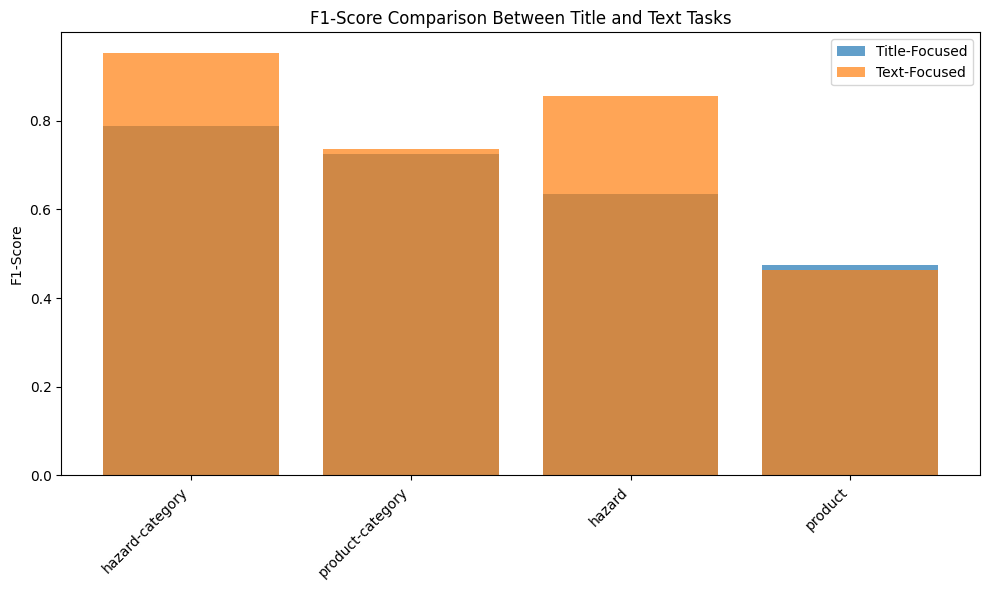

In [ ]:
# Create DataFrames for F1 scores for title and text
f1_scores_title_df = pd.DataFrame({
    'Task': subtask1 + subtask2,
    'F1-Score': title_f1_scores
})

f1_scores_text_df = pd.DataFrame({
    'Task': subtask1 + subtask2,
    'F1-Score': text_f1_scores
})

# Print the collected F1-scores for title
print("\nCollected F1-Scores for Title-Focused Classification:")
print(f1_scores_title_df)

# Print the collected F1-scores for text
print("\nCollected F1-Scores for Text-Focused Classification:")
print(f1_scores_text_df)

# Plot F1-scores for visual comparison
plt.figure(figsize=(10, 6))
plt.bar(f1_scores_title_df['Task'], f1_scores_title_df['F1-Score'], alpha=0.7, label='Title-Focused')
plt.bar(f1_scores_text_df['Task'], f1_scores_text_df['F1-Score'], alpha=0.7, label='Text-Focused')
plt.ylabel("F1-Score")
plt.title("F1-Score Comparison Between Title and Text Tasks")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


The Text-Focused approach consistently achieves better or comparable F1-scores across all tasks, suggesting that incorporating more text-based features enhances the model's ability to classify or predict effectively in these tasks. Tasks involving "product" appear to be more challenging than "category" tasks overall, as seen in their lower F1-scores.